In [1]:
import sys
sys.path.insert(1, '/Users/dpr/mmc_genomics/src')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from denoise import denoise

In [3]:
chroms = ['2L', '2R', '3L', '3R']
recomb_dir = "../data/recombination_maps/Comeron_tables/"
maf_dir = '../data/'

# Recombination map

Import recombination map and apply the wavelet denoising procedure.

In [4]:
wavelet = 'db4'
t = 4.5

W = []
R_raw = []
R = []
for chrom in chroms:
    w_start_r, r_raw = np.loadtxt(recomb_dir +
                                  'Comeron_100kb_chr{}.txt'.format(chrom), unpack=True)
    min_r = min(r_raw[r_raw>0])
    rem, recomb_norm = np.modf(r_raw / min_r)
    r_denoised = denoise(recomb_norm, t=t, wavelet=wavelet)*min_r
    W.append(w_start_r)
    R_raw.append(r_raw)
    R.append(r_denoised)

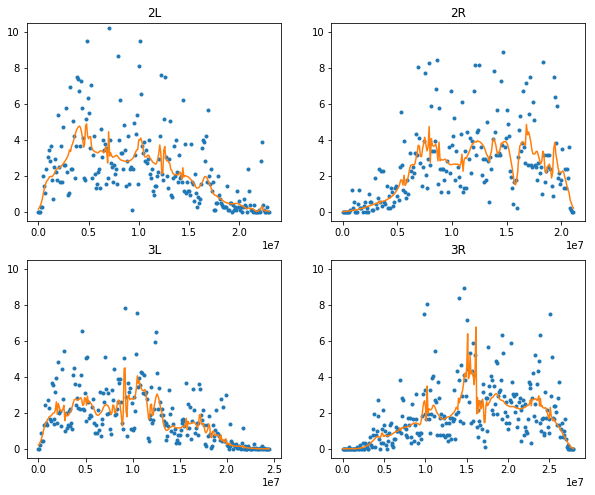

In [5]:
fig = plt.figure(figsize=(10,8))
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.plot(W[i], R_raw[i],'.')
    ax.plot(W[i], R[i])
    ax.set_ylim([-0.5,10.5])
    ax.set_title(chroms[i])
plt.show()

We'll want to choose recombination rate cut-offs for our bins, so let's look at a histogram of $r$.

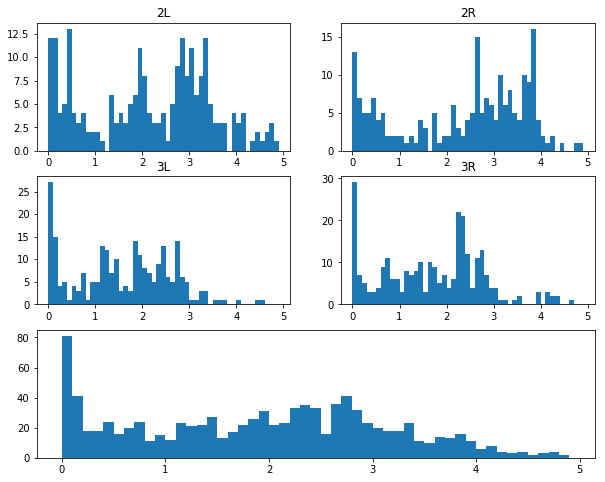

In [6]:
fig = plt.figure(figsize=(10,8))
for i in range(4):
    ax = plt.subplot(3,2,i+1)
    ax.hist(R[i], bins=np.arange(0,5,0.1))
    ax.set_title(chroms[i])
ax = plt.subplot(3,1,3)
ax.hist(np.concatenate(R), bins=np.arange(0,5,0.1))
plt.show()

The distribution is fairly uniform for $r>0$, so a reasonable starting-point might be uniform bins with $\Delta r = 1.0$ starting at $r=0.5$.

In [7]:
r_bins = np.arange(0.5,5.0,1.0)
print(np.histogram(np.concatenate(R), bins=r_bins))

(array([191, 255, 238,  89]), array([ 0.5,  1.5,  2.5,  3.5,  4.5]))


Let's see how these bins are distributed along the genome. We don't want any bin to be too localized in a single place.

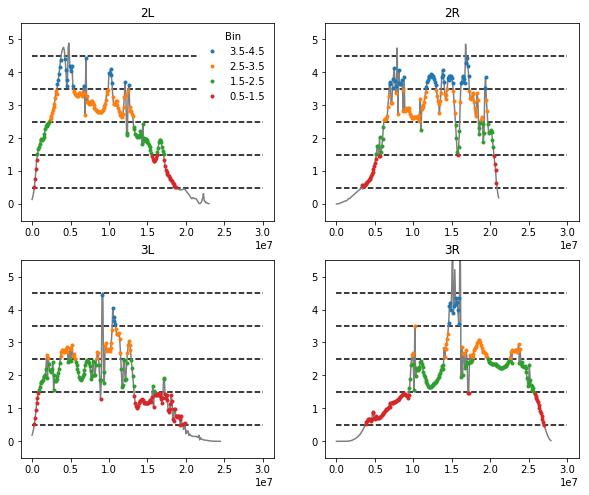

In [8]:
fig = plt.figure(figsize=(10,8))
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    w = W[i]
    r = R[i]
    ax.plot(w,r,'-',c='0.5')
    for j in range(4)[::-1]:
        in_bin = np.logical_and(r >= r_bins[j], r < r_bins[j+1])
        ax.plot(w[in_bin], r[in_bin],'.', label='{}-{}'.format(r_bins[j], r_bins[j+1]))
    ax.hlines(r_bins, 0, 3e7, linestyle='dashed')
    ax.set_ylim([-0.5,5.5])
    ax.set_title(chroms[i])
    if i == 0:
        ax.legend(title='Bin', facecolor='w', edgecolor='w', framealpha=1.0)
plt.show()

Seems reasonably well-distributed. We should revisit this point later. Ideally, we'll go to some sort of continuous version rather than discrete bins.

# Diversity data

First, we'll test everything on a single chromosome arm. Chr2R seems like it has a good distribution of $r$, so we'll start there. First, import the minor allele frequency at each site.

In [122]:
test_chrom = '2R'
maf = np.loadtxt(maf_dir + 'Chr{}.maf.txt.gz'.format(test_chrom), dtype='float16')

In [123]:
w = W[chroms.index(test_chrom)]
r = R[chroms.index(test_chrom)]
print(w.shape, r.shape)
n_windows = len(w)

(212,) (212,)


In [124]:
n_bins = len(r_bins)-1
in_bins = np.empty((n_bins,n_windows), dtype=bool)
for i in range(n_bins):
    in_bins[i,:] = np.logical_and(r >= r_bins[i], r < r_bins[i+1])

To correspond with the recombination map, want to reshape the MAF vector into a 2D array corresponding to the 100kb windows of the r map.

In [125]:
dw = 100000
l_pad = dw - len(maf)%dw
maf_loci = np.pad(maf, (0,l_pad), 'constant', constant_values=np.nan).reshape((-1, dw))
print(maf_loci.shape)

(212, 100000)


As a sanity check, let's calculate some basic diversity statistics.

In [126]:
n_samples = 100
max_maf = n_samples//2
freqs = np.arange(max_maf + 1)
pi_weights = 2.0*freqs*(n_samples-freqs)/(n_samples**2)

First, we'll get the site frequency spectrum in windows, which will allow us to get the global SFS and $\pi$ as well as $\pi$ in windows.

In [127]:
sfs_windows = np.empty((n_windows, max_maf+1))
for i in range(n_windows):
    data = maf_loci[i,:]
    sfs_windows[i,:] = np.histogram(data[~np.isnan(data)], bins=np.arange(max_maf + 2))[0]

In [128]:
sfs_total = np.sum(sfs_windows, axis=0)/np.sum(sfs_windows)
pi_total = np.dot(pi_weights, sfs_total)
print('Global pi = {:.4f}'.format(pi_total))

Global pi = 0.0068


First, let's compare the global site frequency spectrum to its neutral, constant $N$ expectation:

In [129]:
sfs_neut = pi_total * (1.0/freqs + 1.0/(n_samples-freqs))
sfs_neut[0] = 1.0 - np.sum(sfs_neut[1:])

/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


Check that the two distributions have the same $\pi$.

In [130]:
print('Observed:', np.dot(sfs_total, pi_weights))
print('Expected:', np.dot(sfs_neut, pi_weights))

Observed: 0.0068145044641
Expected: 0.0068145044641


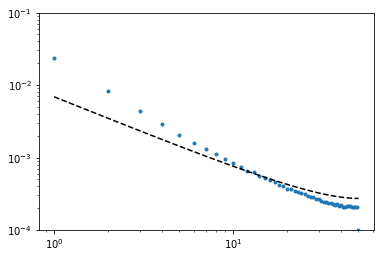

In [131]:
plt.loglog(sfs_total, '.')
plt.loglog(freqs, sfs_neut, '--k')
plt.ylim([1e-4, 1e-1])
plt.show()

There's a clear over-abundance of rare alleles in the data compared to expectation.

Now, let's see how diversity varies along the chromosome:

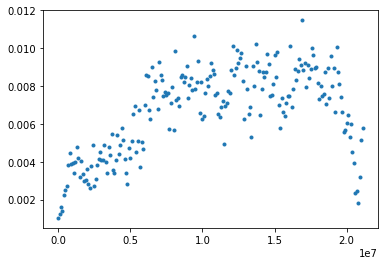

In [132]:
pi_windows = np.dot(sfs_windows, pi_weights)/np.sum(sfs_windows,axis=1)
plt.plot(w, pi_windows,'.')
plt.show()

And how $\pi$ varies with $r$, continuously and with our proposed binning scheme:

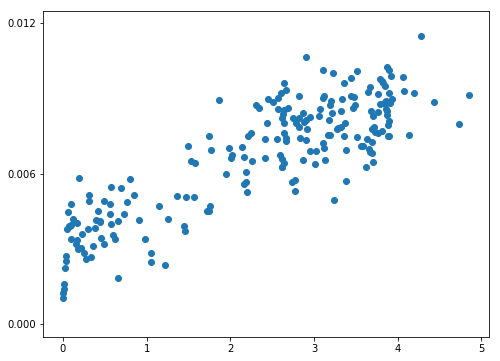

In [133]:
fig = plt.figure(figsize=(8,6))
plt.plot(r, pi_windows, 'o')
plt.ylim([-0.0005, 0.0125])
plt.yticks([0,0.006,0.012])
plt.savefig('pi_vs_r_no_bins.pdf')
plt.show()

[ 0.00425065  0.00670976  0.00793903  0.00847898]


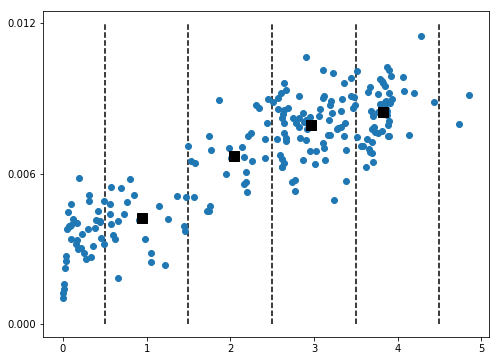

In [134]:
fig = plt.figure(figsize=(8,6))
r_means = np.zeros(n_bins)
pi_means = np.zeros(n_bins)
for i in range(n_bins):
    in_bin = in_bins[i,:]
    r_means[i] = np.mean(r[in_bin])
    pi_means[i] = np.nanmean(pi_windows[in_bin])
print(pi_means)    
plt.plot(r, pi_windows, 'o')
plt.vlines(r_bins,0,0.012, linestyle='dashed')    
plt.plot(r_means, pi_means, 'sk', ms=10)
plt.ylim([-0.0005, 0.0125])
plt.yticks([0,0.006,0.012])
plt.savefig('pi_vs_r_bins.pdf')
plt.show()

In [135]:
print(r_means)
print(pi_means)

[ 0.93959453  2.04965577  2.96985762  3.82122277]
[ 0.00425065  0.00670976  0.00793903  0.00847898]


We can calculate $\pi$ and the site frequency spectrum in each of our $r$ bins and compare the latter to neutral, constant $N$ expectation given the former.

In [136]:
sfs_bins = np.zeros((n_bins, max_maf+1))
for i in range(n_bins):
    sfs_bins[i] = np.sum(sfs_windows[in_bins[i]], axis=0)
    sfs_bins[i] /= np.sum(sfs_bins[i])
    
pi_bins = np.dot(sfs_bins, pi_weights)
print(pi_bins)

[ 0.00423087  0.00669346  0.00790898  0.00846921]


In [137]:
sfs_neut_bins = pi_bins[:,None] * (1.0/freqs[None,:] + 1.0/(n_samples-freqs[None,:]))
sfs_neut_bins[:,0] = 1.0 - np.sum(sfs_neut_bins[:,1:],axis=1)

/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


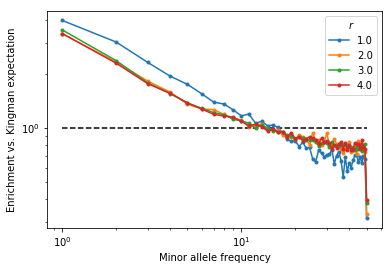

In [138]:
for i in range(n_bins):
    plt.loglog(sfs_bins[i,:] / sfs_neut_bins[i,:], '.-', label=r_bins[i]+.5)
#plt.ylim([1e-3,1])
plt.hlines(1,1,50, linestyle='dashed')
plt.legend(title='$r$')
plt.xlabel('Minor allele frequency')
plt.ylabel('Enrichment vs. Kingman expectation')
plt.show()

The lowest-$r$ bin has the most SFS distortion, but there's no signal among the other bins.

# Joint site frequency spectra (OUT OF DATE)

NOTE: this section is out of date.

We're going to calulate the 2-site joint site frequency spectrum as a function of the distance $d$ between the two sites. That means we have to define some parameters: the values of $d$ to examine and $\Delta d$, the range of $d$ to integrate over in order to reduce sampling noise.

In [54]:
d_list = [3, 10, 30, 100, 300, 1000]
delta_d = 10

in_bin = np.logical_or(in_bins[1], in_bins[2])
# Calculate joint site frequency spectrum from d to d+delta_d
Jsfs = np.zeros((len(d_list), max_maf+1, max_maf+1))
for i_d, d_start in enumerate(d_list):
    for d in range(d_start, d_start+delta_d):
        pairs = np.empty((np.count_nonzero(in_bin), dw-d, 2))
        pairs[:,:,0] = maf_loci[in_bin, :-d]
        pairs[:,:,1] = maf_loci[in_bin, d:]
        pairs = pairs.reshape((-1,2))
        pairs_safe = pairs[~np.isnan(np.sum(pairs,axis=1))]
        Jsfs[i_d,:,:] += np.histogram2d(pairs_safe[:,0], pairs_safe[:,1],
                                      np.arange(max_maf + 2))[0]
Jsfs += np.transpose(Jsfs, axes=(0,2,1))
Jsfs /= np.nansum(Jsfs, axis=(1,2))[:,None,None]
# Get the marginal site frequency spectrum
Msfs = np.nansum(Jsfs,axis=2)

Check that we didn't mess up the marginal sfs and that it's the same for different distances.

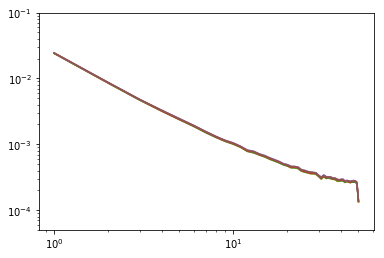

In [55]:
plt.loglog(Msfs.T)
plt.ylim([5e-5,1e-1])
plt.show()

Calculate pointwise mutatual information, mutual information, and $\pi$. Note that $I$ scales like $\pi^2$.

In [56]:
PMI = np.log2(Jsfs / (Msfs[:,:,None]*Msfs[:,None,:]))
MI = np.nansum(Jsfs*PMI, axis=(1,2))
pi_d = np.dot(Msfs, pi_weights)
print(MI)
print(pi_d)
print(MI/pi_d**2)

[  5.67914409e-04   3.17230837e-04   1.85221650e-04   6.51257178e-05
   2.39933548e-05   2.35474635e-05]
[ 0.00825067  0.008141    0.00816271  0.00833236  0.00853389  0.00845457]
[ 8.34264831  4.78652452  2.77985947  0.9380304   0.32945547  0.32942825]


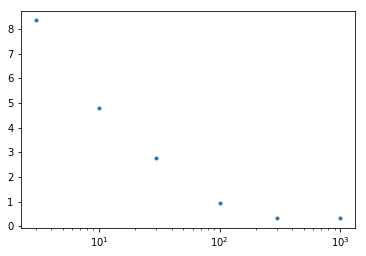

In [57]:
plt.semilogx(d_list, MI/pi_d**2, '.')
plt.show()

# JSFS vs. $r$

In [139]:
#d_list = [3, 6, 10, 15, 20, 25, 30, 60, 100, 300, 1000, 3000, 10000]
d_list = np.logspace(1,4,13, dtype=int)
delta_d = 5

JSFS = np.zeros((n_bins, len(d_list), max_maf+1, max_maf+1))
# Loop over the r bins, get the boolean array in_bin
for i_bin, in_bin in enumerate(in_bins):
    # Calculate joint site frequency spectrum from d to d+delta_d
    for i_d, d_start in enumerate(d_list):
        for d in range(d_start, d_start+delta_d):
            pairs = np.empty((np.count_nonzero(in_bin), dw-d, 2))
            pairs[:,:,0] = maf_loci[in_bin, :-d]
            pairs[:,:,1] = maf_loci[in_bin, d:]
            pairs = pairs.reshape((-1,2))
            pairs_safe = pairs[~np.isnan(np.sum(pairs,axis=1))]
            JSFS[i_bin,i_d,:,:] += np.histogram2d(pairs_safe[:,0], pairs_safe[:,1],
                                                  np.arange(max_maf + 2))[0]
JSFS += np.transpose(JSFS, axes=(0,1,3,2))
JSFS /= np.nansum(JSFS, axis=(2,3))[:,:,None,None]

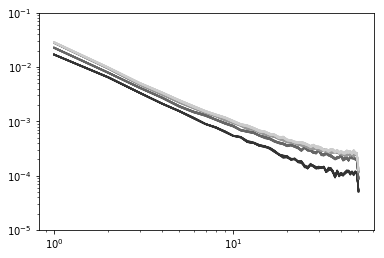

In [140]:
# Get the marginal site frequency spectrum
MSFS = np.nansum(JSFS,axis=3)

for i in range(n_bins):
    #print("r =",r_bins[i]+0.5)
    r = r_bins[i]+0.5
    plt.loglog(MSFS[i,:,:].T, color=str(r/5))
plt.ylim([1e-5,1e-1])
plt.show()

In [141]:
PMI = np.log2(JSFS / (MSFS[:,:,:,None]*MSFS[:,:,None,:]))
wPMI = JSFS*PMI
MI = np.nansum(JSFS*PMI, axis=(2,3))
PI = np.dot(MSFS, pi_weights)

/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [142]:
mu = 2.8e-9
a = 1e-8/(2*mu)

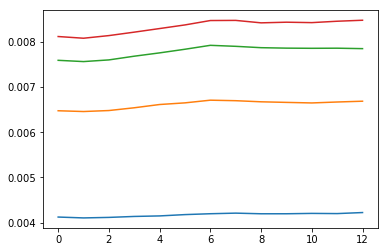

In [143]:
plt.plot(PI.T)
plt.show()

In [144]:
wPMI_clean = np.copy(wPMI[:,:,1:,1:])
wPMI_clean[np.isinf(wPMI[:,:,1:,1:])] = 0
wPMI_clean[np.isnan(wPMI[:,:,1:,1:])] = 0
diag = np.nansum(np.diagonal(wPMI_clean, axis1=2, axis2=3), axis=2)
offdiag = np.nansum(wPMI_clean, axis=(2,3)) - diag

In [145]:
print(wPMI_clean.shape)

(4, 13, 50, 50)


In [146]:
print(PI.shape)

(4, 13)


In [147]:
print(wPMI_clean[0,0,:,:])

[[  8.37700918e-05   2.76692344e-05   1.17847691e-05 ...,   1.41410474e-06
    1.43674506e-06   1.26363731e-06]
 [  2.76692344e-05   2.42680203e-05   9.77078965e-06 ...,   2.29526256e-07
   -2.19132590e-07   2.83870119e-07]
 [  1.17847691e-05   9.77078965e-06   9.64927028e-06 ...,   9.48250664e-08
    6.52969338e-07   3.09116344e-07]
 ..., 
 [  1.41410474e-06   2.29526256e-07   9.48250664e-08 ...,   3.35622246e-07
    3.36527859e-07   0.00000000e+00]
 [  1.43674506e-06  -2.19132590e-07   6.52969338e-07 ...,   3.36527859e-07
    2.21598907e-06   1.76259762e-07]
 [  1.26363731e-06   2.83870119e-07   3.09116344e-07 ...,   0.00000000e+00
    1.76259762e-07   0.00000000e+00]]


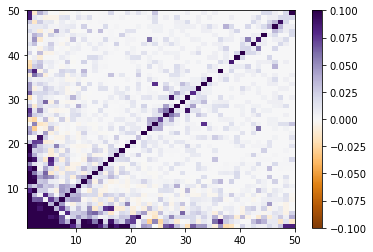

In [165]:
x = np.arange(1,51)
plt.pcolormesh(x,x,wPMI_clean[0,0,:,:]/PI[0,0]**2, cmap='PuOr', vmin=-0.1, vmax=0.1)
#plt.xscale('log')
#plt.yscale('log')
plt.colorbar()
plt.show()

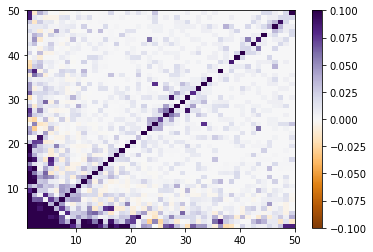

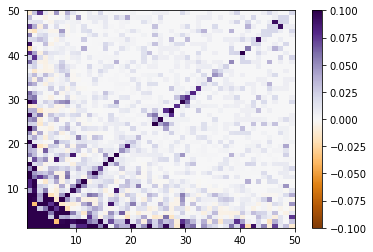

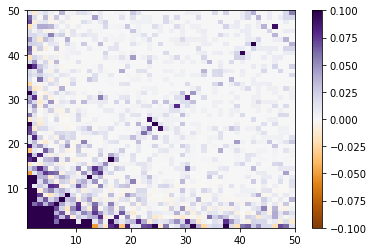

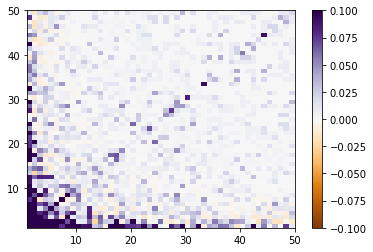

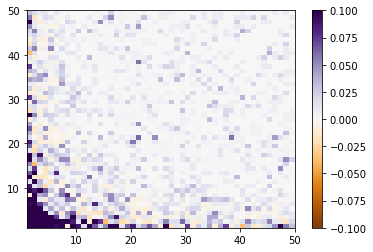

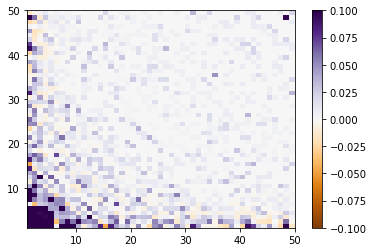

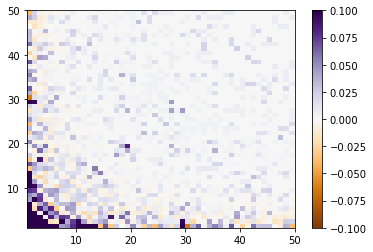

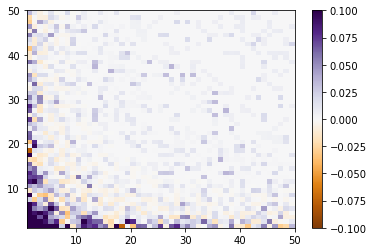

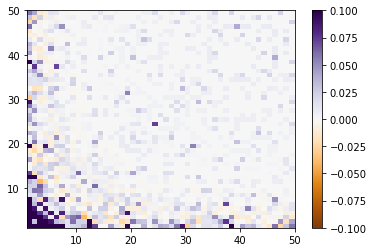

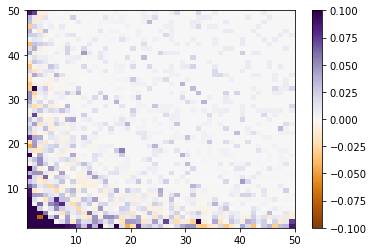

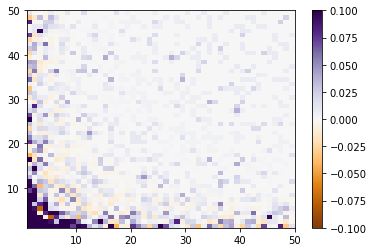

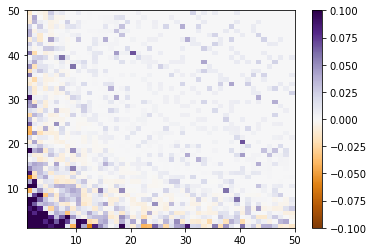

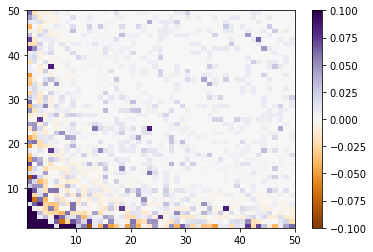

In [166]:
for i, d in enumerate(d_list):
    plt.pcolormesh(x,x,wPMI_clean[0,i,:,:]/PI[0,i]**2, cmap='PuOr', vmin=-0.1, vmax=0.1)
    plt.colorbar()
    #plt.xscale('log')
    #plt.yscale('log')
    plt.show()

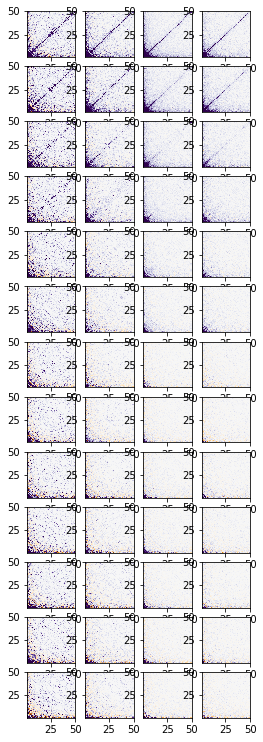

In [167]:
fig = plt.figure(figsize=(4,len(d_list)))
for i_r in range(4):
    for i_d, d in enumerate(d_list):
        ax = fig.add_subplot(len(d_list), 4, i_d*4 + i_r + 1)
        ax.pcolormesh(x,x,wPMI_clean[i_r,i_d,:,:]/PI[i_r,i_d]**2, cmap='PuOr', vmin=-0.05, vmax=0.05)
        #plt.colorbar()
        #ax.set_yscale('log')
        #ax.set_xscale('log')
plt.show()

0.939594532076 0.00417532847516 2.0
2.04965577087 0.00660938959831 2.0
2.96985762222 0.00777451781554 2.0
3.82122276863 0.0083290574736 2.0


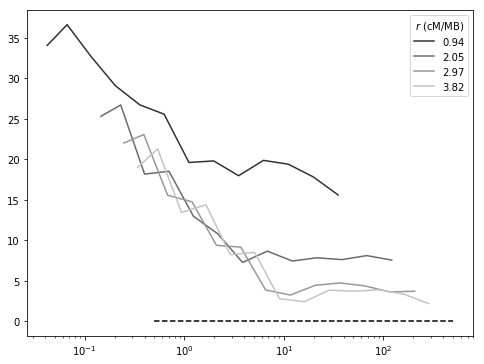

In [151]:
plt.figure(figsize=(8,6))
for i in range(n_bins):
    r = r_means[i]
    pi = np.mean(PI[i,:])
    print(r, pi, (delta_d-1)/2)
    plt.semilogx(a*(np.array(d_list)+((delta_d-1)/2))*r*pi/2,
                 offdiag[i,:]/pi**2,
                 color=str(r/5), label='{:.2f}'.format(r))

plt.hlines(0,0.5,500, linestyle='dashed')
plt.legend(title=r'$r$ (cM/MB)')
plt.show()

# All chromosomes (BROKEN)

NOTE: Something's broken in this section.

In [ ]:
maf_dict = {}
for chrom in chroms:
    print("Importing chr{}...".format(chrom))
    maf_dict[chrom] = np.loadtxt(maf_dir + 'Chr{}.maf.txt.gz'.format(chrom), dtype='float16')

In [ ]:
for c in chroms:
    print(len(maf_dict[c]))

In [ ]:
for i in range(n_bins):
    print(r_bins[i], r_bins[i+1])

In [ ]:
#dw = 100000
in_bins_dict = {}
maf_loci_dict = {}
for i_chr, chrom in enumerate(chroms):
    n_windows = len(W[i_chr])

    # Get boolean in_bins for each chromosome
    in_bins = np.empty((n_bins,n_windows), dtype=bool)
    for i_bin in range(n_bins):
        in_bins[i_bin,:] = np.logical_and(R[i_chr] >= r_bins[i_bin],
                                          R[i_chr] < r_bins[i_bin+1])
    in_bins_dict[chrom] = in_bins
    
    # Get the maf parsed into loci for each chromosome
    maf = maf_dict[chrom]
    l_pad = dw - len(maf)%dw
    maf_loci = np.pad(maf, (0,l_pad), 'constant', constant_values=np.nan).reshape((-1, dw))
    maf_loci_dict[chrom] = maf_loci

In [ ]:
fig = plt.figure(figsize=(8,16))

for i_chr, chrom in enumerate(chroms):
    w = W[i_chr]
    r = R[i_chr]
    n_windows = len(w)
    maf_loci = maf_loci_dict[chrom]
    in_bins = in_bins_dict[chrom]

    sfs_windows = np.empty((n_windows, max_maf+1))
    for i_w in range(n_windows):
        data = maf_loci[i_w,:]
        sfs_windows[i_w,:] = np.histogram(data[~np.isnan(data)],
                                          bins=np.arange(max_maf + 2))[0]
        
    sfs_chrom = np.sum(sfs_windows, axis=0)/np.sum(sfs_windows)
    pi_chrom = np.dot(pi_weights, sfs_chrom)
    print('Chr{0} pi = {1:.4f}'.format(chrom, pi_chrom))
    
    #sfs_neut = pi_chrom * (1.0/freqs + 1.0/(n_samples-freqs))
    #sfs_neut[0] = 1.0 - np.sum(sfs_neut[1:])
    ax1 = plt.subplot(611)
    ax1.loglog(sfs_chrom/sfs_chrom[1], '.', label=chrom)
    
    #r_means = np.zeros(n_bins)
    #pi_means = np.zeros(n_bins)
    #for i in range(n_bins):
    #    in_bin = in_bins[i,:]
    #    r_means[i] = np.mean(r[in_bin])
    #    pi_means[i] = np.mean(pi_windows[in_bin])
        
    pi_windows = np.dot(sfs_windows, pi_weights)/np.sum(sfs_windows,axis=1)
    ax2 = plt.subplot(6,2,3+i_chr)    
    ax2.plot(r, pi_windows, '.')
    ax2.vlines(r_bins,0,0.012, linestyle='dashed')    
    #ax2.plot(r_means, pi_means, 'sk')
    ax2.set_title('Chr{}'.format(chrom))
    
sfs_neut = (1.0/freqs + 1.0/(n_samples-freqs))
sfs_neut /= sfs_neut[1]
ax1.loglog(freqs[1:], sfs_neut[1:], '--k')
ax1.set_ylim([2e-3, 2e0])
ax1.legend()
plt.show()

Chr2L has higher pi, the SFS Chr3L looks different from the others, and the relationship between pi and r looks a little different from chromosome to chromosome.

In [ ]:
#d_list = [3, 6, 10, 15, 20, 25, 30, 60, 100, 300, 1000]
d_list = [3, 10, 30, 100]
delta_d = 3

jsfs_dict = {}
for chrom in chroms:
    in_bins = in_bins_dict[chrom]
    maf_loci = maf_loci_dict[chrom]
    JSFS = np.zeros((n_bins, len(d_list), max_maf+1, max_maf+1))
    # Loop over the r bins, get the boolean array in_bin
    for i_bin, in_bin in enumerate(in_bins):
        # Calculate joint site frequency spectrum from d to d+delta_d
        for i_d, d_start in enumerate(d_list):
            for d in range(d_start, d_start+delta_d):
                pairs = np.empty((np.count_nonzero(in_bin), dw-d, 2))
                pairs[:,:,0] = maf_loci[in_bin, :-d]
                pairs[:,:,1] = maf_loci[in_bin, d:]
                pairs = pairs.reshape((-1,2))
                pairs_safe = pairs[~np.isnan(np.sum(pairs,axis=1))]
                JSFS[i_bin,i_d,:,:] += np.histogram2d(pairs_safe[:,0], pairs_safe[:,1],
                                                      np.arange(max_maf + 2))[0]
    JSFS += np.transpose(JSFS, axes=(0,1,3,2))
    JSFS /= np.nansum(JSFS, axis=(2,3))[:,:,None,None]
    jsfs_dict[chrom] = JSFS

In [ ]:
r_means_dict = {}
for i_chr, chrom in enumerate(chroms):
    r = R[i_chr]
    r_means = np.zeros(n_bins)
    in_bins = in_bins_dict[chrom]
    for i in range(n_bins):
        in_bin = in_bins[i,:]
        print(chrom, r.shape, in_bin.shape)
        r_means[i] = np.mean(r[in_bin])
    r_means_dict[chrom] = r_means
    print(r_means)

In [ ]:
# Get the marginal site frequency spectrum
msfs_dict = {chrom : np.nansum(jsfs_dict[chrom],axis=3) for chrom in chroms}

In [ ]:
plt.figure(figsize=(8,8))
for i_chr, chrom in enumerate(chroms):
    ax = plt.subplot(2,2,i_chr+1)
    for i in range(n_bins):
        r = r_bins[i]+0.5
        plt.loglog(msfs_dict[chrom][i,:,:].T, color=str(r/5))
    plt.ylim([1e-5,1e-1])
plt.show()

In [ ]:
pmi_dict = {}
wpmi_dict = {}
#mi_dict = {}
pi_dict = {}
offdiag_dict = {}
for chrom in chroms:
    print(chrom)
    JSFS = jsfs_dict[chrom]
    MSFS = msfs_dict[chrom]
    pmi_dict[chrom] = np.log2(JSFS / (MSFS[:,:,:,None]*MSFS[:,:,None,:]))
    wPMI = JSFS*pmi_dict[chrom]
    wPMI[np.isinf(wPMI)] = 0
    wPMI[np.isnan(wPMI)] = 0
    wpmi_dict[chrom] = wPMI[:,:,1:,1:]
    
    diag = np.sum(np.diagonal(wPMI, axis1=2, axis2=3), axis=2)
    print(diag.shape)
    offdiag = np.sum(wPMI, axis=(2,3)) - diag
    print(offdiag.shape)
    print(offdiag)

    offdiag_dict[chrom] = offdiag
    #mi_dict[chrom] = np.nansum(JSFS*pmi_dict[chrom], axis=(2,3))
    pi_dict[chrom] = np.dot(MSFS, pi_weights)

In [ ]:
for chrom in chroms:
    print(chrom)
    plt.plot(pi_dict[chrom].T)
    print(pi_dict[chrom])
    plt.show()

In [ ]:
for i_chr, chrom in enumerate(chroms):
    print(chrom)
    fig = plt.figure()    
    for i_r in range(4):
        for i_d, d in enumerate(d_list):
            ax = fig.add_subplot(len(d_list), 4, i_d*4 + i_r + 1)
            ax.pcolormesh(wpmi_dict[chrom][i_r,i_d,:,:]/pi_dict[chrom][i_r,i_d]**2, cmap='PuOr', vmin=-0.05, vmax=0.05)
            #plt.colorbar()
    plt.show()


In [ ]:
for i_chr, chrom in enumerate(chroms):
    print(chrom)
    offdiag = offdiag_dict[chrom]
    PI = pi_dict[chrom]
    r_means = r_means_dict[chrom]
    #plt.plot(offdiag)
    #plt.show()
    
    plt.figure(figsize=(8,6))
    for i in range(n_bins):
        #r = r_means[i]
        #pi = np.mean(PI[i,:])
        plt.plot(offdiag[i,:])
        #plt.semilogx(a*(np.array(d_list)+((delta_d-1)/2))*r*pi/2,
        #         offdiag[i,:]/pi**2,
        #         color=str(r/5), label='{:.2f}'.format(r))

    #plt.hlines(0,0.5,500, linestyle='dashed')
    #plt.legend(title=r'$r$ (cM/MB)')
    plt.show()

In [ ]:
plt.figure(figsize=(8,8))
for i_chr, chrom in enumerate(chroms):
    MI = mi_dict[chrom]
    PI = pi_dict[chrom]
    for i in range(n_bins):
        r = r_bins[i]+0.5
        #r = r_means[i]

        ax = plt.subplot(2,2,i_chr+1)
        plt.semilogx(np.array(d_list)+1, MI[i,:]/PI[i,:]**2, color=str(r/5))

        #ax = plt.subplot(3,1,2)
        #plt.semilogx((np.array(d_list)+1)*r, MI[i,:]/PI[i,:]**2, color=str(r/5))

        #ax = plt.subplot(3,1,3)
        #plt.semilogx(a*(np.array(d_list)+1)*r*np.mean(PI[i,:]), MI[i,:]/PI[i,:]**2, color=str(r/5))
plt.show()

This looks wrong. Check the pointwise:

In [ ]:
for chrom in chroms:
    print(chrom)
    PMI = pmi_dict[chrom]
    PI = pi_dict[chrom]
    PMI_nan = np.copy(PMI)
    PMI_nan[np.isinf(PMI)] = np.nan
    
    for i in range(n_bins):
        print("r =", r_bins[i]+0.5)
        for j in range(len(d_list)):
            d_scaled = a*(d_list[j]+1)*(r_bins[i]+0.5)*PI[i,j]
            c = str((np.log10(d_scaled)+2)/4)
            plt.semilogx(np.nanmean(PMI_nan[i,j,0:,0:], axis=1), color=c)
        plt.ylim([-0.1,2.1])
        plt.show()

It looks like something is getting scrambled here.